# DDP for 2 Heated Tanks - Mode 1

This notebook implements Differential Dynamic Programming (DDP) for the two heated tanks system in mode 1 (ON1 AND OFF2).

In [69]:
import numpy as np
import bisect as bi
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt

## Helper Functions

In [70]:
def edInt(a, s, b):
    """Create evenly discretized interval from a to b with step s"""
    return np.linspace(a, b, int(np.floor((b-a)/s)))

def idx(aList, val):
    """Find nearest index in sorted list for given value"""
    i = bi.bisect(aList, val)  # right
    if i <= 0:  # first
        pass
    elif len(aList) == i:  # last
        i -= 1
    elif val - aList[i-1] < aList[i] - val:  # left
        i -= 1
    return i

def lookup(aList, vals):
    """Find nearest indices for multiple values (poorman's nearest-neighbor interpolation)"""
    indices = []
    v = vals
    if type(v) in [int, float, np.float64]:
        v = [v]
    for k in np.sort(v):
        indices.append(idx(aList, k))
    return np.array(indices, dtype=np.uint32)

def bilinear_interp(grid1, grid2, V_grid, val1, val2):
    """
    Bilinear interpolation using idx and lookup functions.
    
    Args:
        grid1: 1D array for first dimension (e.g., T1_grid)
        grid2: 1D array for second dimension (e.g., T2_grid)
        V_grid: 2D array of values at grid points (indexed as [i2, i1])
        val1: value in first dimension to interpolate
        val2: value in second dimension to interpolate
    
    Returns:
        Interpolated value
    """
    # Find indices using bisect
    i1 = bi.bisect(grid1, val1)
    i2 = bi.bisect(grid2, val2)
    
    # Clamp to grid boundaries
    i1_low = max(0, min(i1 - 1, len(grid1) - 2))
    i1_high = i1_low + 1
    i2_low = max(0, min(i2 - 1, len(grid2) - 2))
    i2_high = i2_low + 1
    
    # Get grid values
    x1_low, x1_high = grid1[i1_low], grid1[i1_high]
    x2_low, x2_high = grid2[i2_low], grid2[i2_high]
    
    # Clamp interpolation values to grid bounds
    val1 = np.clip(val1, x1_low, x1_high)
    val2 = np.clip(val2, x2_low, x2_high)
    
    # Compute weights
    if x1_high - x1_low > 1e-10:
        w1 = (val1 - x1_low) / (x1_high - x1_low)
    else:
        w1 = 0.0
    
    if x2_high - x2_low > 1e-10:
        w2 = (val2 - x2_low) / (x2_high - x2_low)
    else:
        w2 = 0.0
    
    # Bilinear interpolation
    V_interp = (1 - w2) * ((1 - w1) * V_grid[i2_low, i1_low] + w1 * V_grid[i2_low, i1_high]) + \
               w2 * ((1 - w1) * V_grid[i2_high, i1_low] + w1 * V_grid[i2_high, i1_high])
    
    return V_interp

## System Parameters

Mode 1 dynamics (ON1 AND OFF2):

$$\dot{T}_1 = -a_1 T_1 + b_1 T_2 + h_1 u_1$$
$$\dot{T}_2 = b_2 T_1 - a_2 T_2 + h_2 u_2$$

In [71]:
# System parameters
a1 = 0.01   # Heat loss coefficient tank 1
a2 = 0.01   # Heat loss coefficient tank 2
b1 = 0.005  # Coupling coefficient 2→1
b2 = 0.005  # Coupling coefficient 1→2
h1 = 2.0    # Heater gain tank 1
h2 = 2.0    # Heater gain tank 2

print(f"System parameters:")
print(f"a1={a1}, a2={a2}, b1={b1}, b2={b2}, h1={h1}, h2={h2}")

System parameters:
a1=0.01, a2=0.01, b1=0.005, b2=0.005, h1=2.0, h2=2.0


## DDP Settings

In [72]:
# Time horizon
t0 = 0
dt = 0.5     # Time step
tf = 50      # Final time
T = edInt(t0, dt, tf)
N = T.size

# State space discretization (temperature ranges)
dT1 = 2.0    # Temperature step for tank 1
dT2 = 2.0    # Temperature step for tank 2
T1_min, T1_max = 0, 120    # Tank 1 temperature range C
T2_min, T2_max = 0, 120    # Tank 2 temperature range C

# Control space discretization
du1 = 0.5    # Control step for heater 1
du2 = 0.5    # Control step for heater 2
u1_min, u1_max = 0, 5     # Control range for heater 1
u2_min, u2_max = 0, 5     # Control range for heater 2

# Create admissible sets
T1_grid = edInt(T1_min, dT1, T1_max)
T2_grid = edInt(T2_min, dT2, T2_max)
U1 = edInt(u1_min, du1, u1_max)
U2 = edInt(u2_min, du2, u2_max)

# Create state space meshgrid
T1, T2 = np.meshgrid(T1_grid, T2_grid)

# Initial and reference states
x0 = np.array([10.0, 40.0])  # Initial temperatures [T1, T2]
x_ref = np.array([25.0, 30.0])  # Reference temperatures [T1, T2]

# Penalties for inadmissible states
infStValInc = 5000
nullCtr = 0

print(f"Time horizon: {t0} to {tf} s with dt={dt} s ({N} steps)")
print(f"State space: T1 in [{T1_min}, {T1_max}] deg C (step {dT1}), T2 in [{T2_min}, {T2_max}] deg C (step {dT2})")
print(f"State grid sizes: {T1_grid.size} x {T2_grid.size} = {T1_grid.size * T2_grid.size} states")
print(f"Control space: u1 in [{u1_min}, {u1_max}] (step {du1}), u2 in [{u2_min}, {u2_max}] (step {du2})")
print(f"Control grid sizes: {U1.size} x {U2.size} = {U1.size * U2.size} control combinations")
print(f"Initial state: T1={x0[0]} deg C, T2={x0[1]} deg C")
print(f"Reference state: T1={x_ref[0]} deg C, T2={x_ref[1]} deg C")

Time horizon: 0 to 50 s with dt=0.5 s (100 steps)
State space: T1 in [0, 120] deg C (step 2.0), T2 in [0, 120] deg C (step 2.0)
State grid sizes: 60 x 60 = 3600 states
Control space: u1 in [0, 5] (step 0.5), u2 in [0, 5] (step 0.5)
Control grid sizes: 10 x 10 = 100 control combinations
Initial state: T1=10.0 deg C, T2=40.0 deg C
Reference state: T1=25.0 deg C, T2=30.0 deg C


## Cost Function

$$L(x, u) = (T_1 - T_1^{ref})^2 Q_1 + (T_2 - T_2^{ref})^2 Q_2 + u_1^2 R_1 + u_2^2 R_2$$

In [73]:
# Cost matrices
Q1 = 100.0   # State cost weight for tank 1
Q2 = 100.0   # State cost weight for tank 2
R1 = 1.0     # Control cost weight for heater 1
R2 = 1.0     # Control cost weight for heater 2

print(f"Cost weights: Q1={Q1}, Q2={Q2}, R1={R1}, R2={R2}")

Cost weights: Q1=100.0, Q2=100.0, R1=1.0, R2=1.0


## Initialize Value Function and Optimal Control Arrays

In [74]:
# Initialize arrays
# V[i, j, k] = optimal cost-to-go from state (T2[i,j], T1[i,j]) at time k
# u1_opt[i, j, k] = optimal control u1 at state (T2[i,j], T1[i,j]) at time k
# u2_opt[i, j, k] = optimal control u2 at state (T2[i,j], T1[i,j]) at time k
V = np.zeros((T2_grid.size, T1_grid.size, N))
u1_opt = np.zeros_like(V)
u2_opt = np.zeros_like(V)

# Terminal cost (at time N-1)
V[:, :, N-1] = Q1 * (T1 - x_ref[0])**2 + Q2 * (T2 - x_ref[1])**2

print(f"Initialized V with shape: {V.shape}")
print(f"Terminal cost V[:,:,{N-1}] set based on reference state")

Initialized V with shape: (60, 60, 100)
Terminal cost V[:,:,99] set based on reference state


## DDP Backward Pass (Value Iteration)

Bellman equation:
$$V(x, k) = \min_{u_1, u_2} \left[ L(x, u) + V(f(x, u), k+1) \right]$$

In [75]:
print("Starting DDP backward pass with bilinear interpolation...")
print(f"Processing {N-1} time steps x {T2_grid.size} x {T1_grid.size} states x {U1.size} x {U2.size} controls")
print(f"Total iterations: {(N-1) * T2_grid.size * T1_grid.size}")
print("This may take a few minutes...\n")

depth = 0  # Start from beginning of horizon
inadmissible_count = 0

for k in range(N-1, depth, -1):
    if k % 10 == 0:
        print(f"Processing time step {k}/{N-1}...")
    
    for i in range(T2_grid.size):
        for j in range(T1_grid.size):
            # Current state
            T1_curr = T1[i, j]
            T2_curr = T2[i, j]
            
            # Initialize minimum cost
            min_cost = float('inf')
            best_u1 = nullCtr
            best_u2 = nullCtr
            
            # Try all control combinations
            for u1_val in U1:
                for u2_val in U2:
                    # Instant cost
                    L = Q1 * (T1_curr - x_ref[0])**2 + Q2 * (T2_curr - x_ref[1])**2 + \
                        R1 * u1_val**2 + R2 * u2_val**2
                    
                    # Predict next state using mode 1 dynamics
                    T1_next = T1_curr + (-a1 * T1_curr + b1 * T2_curr + h1 * u1_val) * dt
                    T2_next = T2_curr + (b2 * T1_curr - a2 * T2_curr + h2 * u2_val) * dt
                    
                    # Check if next state is admissible
                    if (T1_next >= T1_min and T1_next <= T1_max and 
                        T2_next >= T2_min and T2_next <= T2_max):
                        
                        # Use bilinear interpolation to get future cost
                        V_next = bilinear_interp(T1_grid, T2_grid, V[:, :, k], T1_next, T2_next)
                        
                        # Bellman equation: total cost = instant cost + future cost
                        total_cost = L + V_next
                        
                        # Update if this is better
                        if total_cost < min_cost:
                            min_cost = total_cost
                            best_u1 = u1_val
                            best_u2 = u2_val
            
            # Store optimal cost and control
            if min_cost == float('inf'):
                # No admissible control found - penalize
                V[i, j, k-1] = V[i, j, k] + infStValInc
                inadmissible_count += 1
            else:
                V[i, j, k-1] = min_cost
            
            u1_opt[i, j, k-1] = best_u1
            u2_opt[i, j, k-1] = best_u2

print(f"\nDDP backward pass complete!")
print(f"Inadmissible state-time points: {inadmissible_count} / {(N-1) * T2_grid.size * T1_grid.size}")

Starting DDP backward pass with bilinear interpolation...
Processing 99 time steps x 60 x 60 states x 10 x 10 controls
Total iterations: 356400
This may take a few minutes...

Processing time step 90/99...
Processing time step 80/99...
Processing time step 70/99...
Processing time step 60/99...
Processing time step 50/99...
Processing time step 40/99...
Processing time step 30/99...
Processing time step 20/99...
Processing time step 10/99...

DDP backward pass complete!
Inadmissible state-time points: 0 / 356400


## Forward Simulation Using Optimal Policy

In [76]:
# Simulate from initial state
x = np.zeros((N, 2))
x[0, :] = x0
u1_sim = np.zeros(N)
u2_sim = np.zeros(N)

print(f"Starting forward simulation from x0 = {x0}")

for k in range(N-1):
    # Check if current state is admissible
    if not (x[k, 0] >= T1_min and x[k, 0] <= T1_max and
            x[k, 1] >= T2_min and x[k, 1] <= T2_max):
        print(f"Stopped at k={k}/{N}: state [{x[k,0]:.2f}, {x[k,1]:.2f}] out of bounds")
        break
    
    # Get optimal control using bilinear interpolation of control policy
    u1_sim[k] = bilinear_interp(T1_grid, T2_grid, u1_opt[:, :, k], x[k, 0], x[k, 1])
    u2_sim[k] = bilinear_interp(T1_grid, T2_grid, u2_opt[:, :, k], x[k, 0], x[k, 1])
    
    # Propagate dynamics
    x[k+1, 0] = x[k, 0] + (-a1 * x[k, 0] + b1 * x[k, 1] + h1 * u1_sim[k]) * dt
    x[k+1, 1] = x[k, 1] + (b2 * x[k, 0] - a2 * x[k, 1] + h2 * u2_sim[k]) * dt

print(f"Simulation complete!")
print(f"Final state: T1={x[-1,0]:.2f} deg C, T2={x[-1,1]:.2f} deg C")
print(f"Reference: T1={x_ref[0]} deg C, T2={x_ref[1]} deg C")
print(f"Final error: T1={x[-1,0]-x_ref[0]:.2f} deg C, T2={x[-1,1]-x_ref[1]:.2f} deg C")

Starting forward simulation from x0 = [10. 40.]
Simulation complete!
Final state: T1=24.36 deg C, T2=30.43 deg C
Reference: T1=25.0 deg C, T2=30.0 deg C
Final error: T1=-0.64 deg C, T2=0.43 deg C


## Visualization

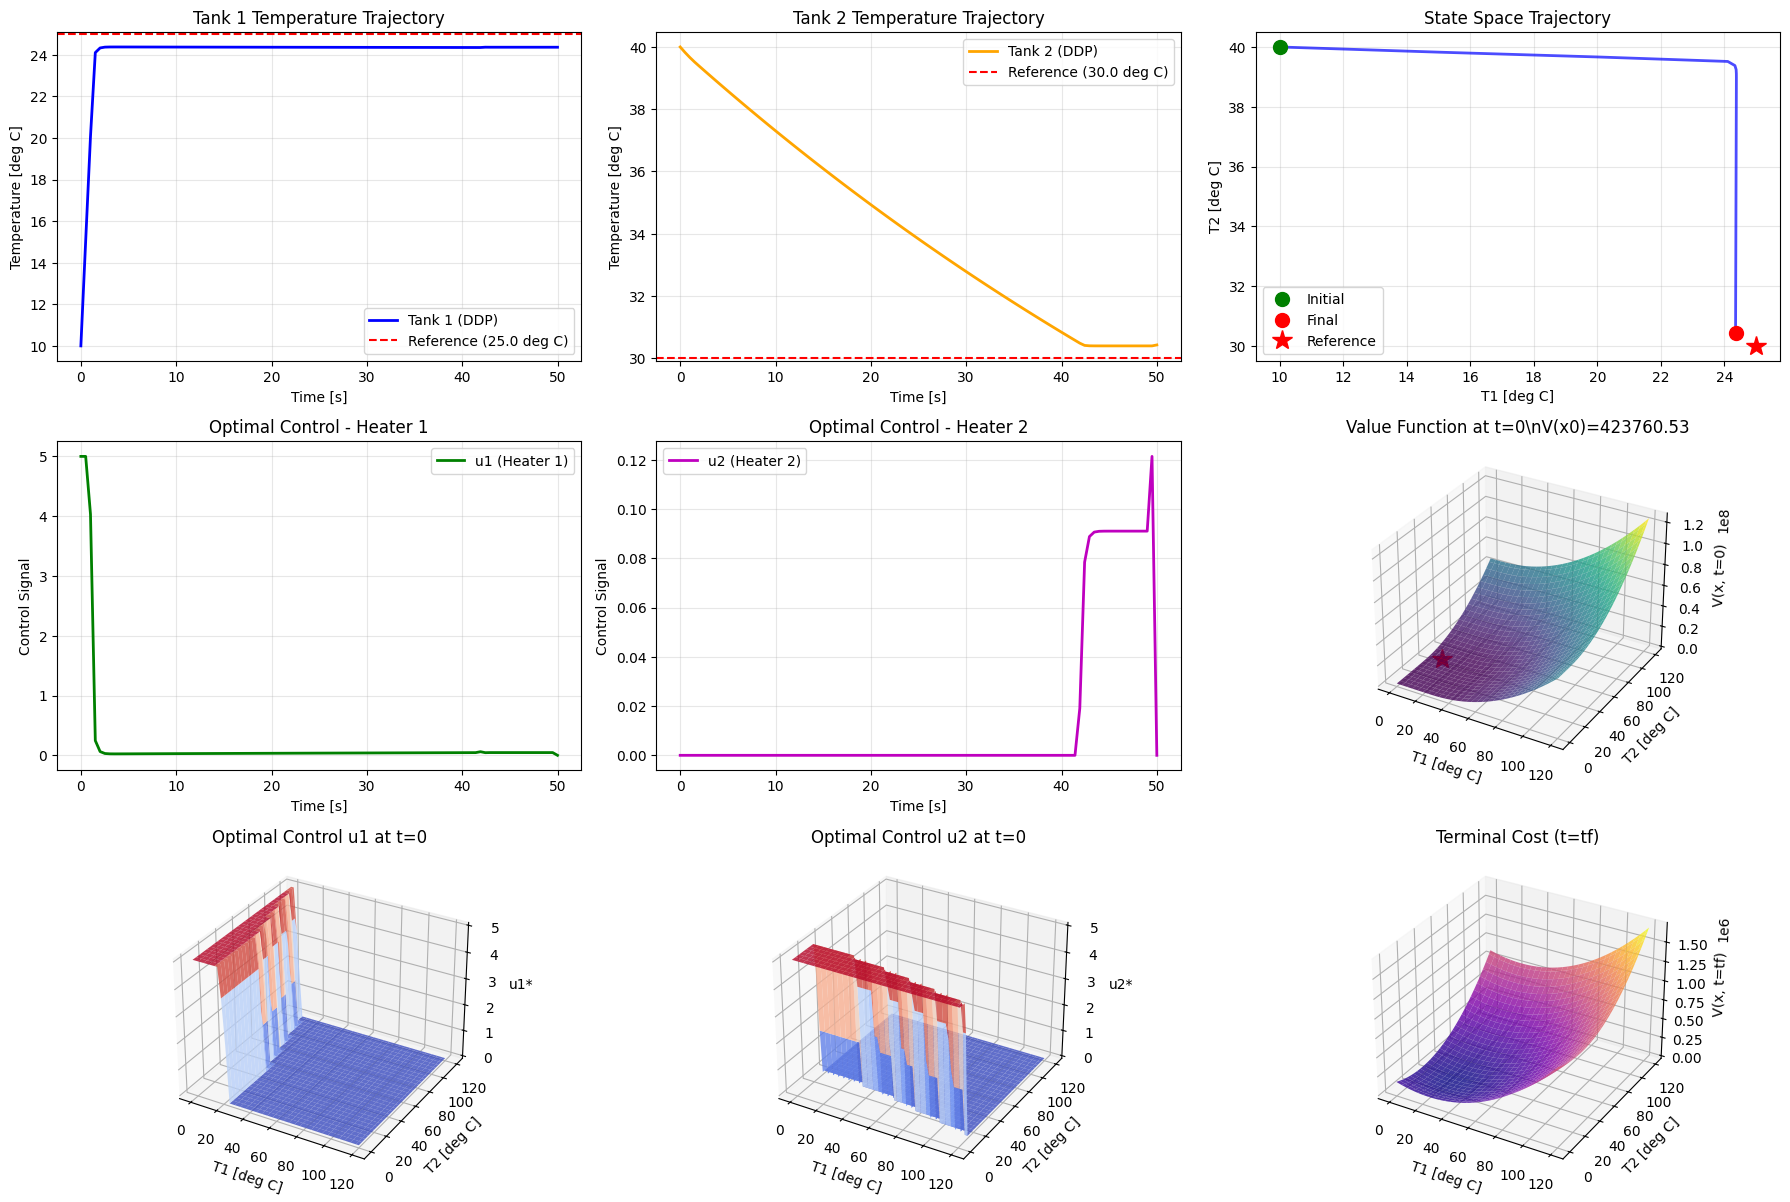

In [77]:
# Create comprehensive visualization
fig = plt.figure(figsize=(18, 12))

# State trajectories
ax1 = plt.subplot(3, 3, 1)
ax1.plot(T, x[:, 0], 'b-', linewidth=2, label='Tank 1 (DDP)')
ax1.axhline(y=x_ref[0], color='red', linestyle='--', label=f'Reference ({x_ref[0]} deg C)')
ax1.set_xlabel('Time [s]')
ax1.set_ylabel('Temperature [deg C]')
ax1.set_title('Tank 1 Temperature Trajectory')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2 = plt.subplot(3, 3, 2)
ax2.plot(T, x[:, 1], 'orange', linewidth=2, label='Tank 2 (DDP)')
ax2.axhline(y=x_ref[1], color='red', linestyle='--', label=f'Reference ({x_ref[1]} deg C)')
ax2.set_xlabel('Time [s]')
ax2.set_ylabel('Temperature [deg C]')
ax2.set_title('Tank 2 Temperature Trajectory')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Control signals
ax3 = plt.subplot(3, 3, 4)
ax3.plot(T, u1_sim, 'g-', linewidth=2, label='u1 (Heater 1)')
ax3.set_xlabel('Time [s]')
ax3.set_ylabel('Control Signal')
ax3.set_title('Optimal Control - Heater 1')
ax3.legend()
ax3.grid(True, alpha=0.3)

ax4 = plt.subplot(3, 3, 5)
ax4.plot(T, u2_sim, 'm-', linewidth=2, label='u2 (Heater 2)')
ax4.set_xlabel('Time [s]')
ax4.set_ylabel('Control Signal')
ax4.set_title('Optimal Control - Heater 2')
ax4.legend()
ax4.grid(True, alpha=0.3)

# State space trajectory
ax5 = plt.subplot(3, 3, 3)
ax5.plot(x[:, 0], x[:, 1], 'b-', linewidth=2, alpha=0.7)
ax5.plot(x[0, 0], x[0, 1], 'go', markersize=10, label='Initial')
ax5.plot(x[-1, 0], x[-1, 1], 'ro', markersize=10, label='Final')
ax5.plot(x_ref[0], x_ref[1], 'r*', markersize=15, label='Reference')
ax5.set_xlabel('T1 [deg C]')
ax5.set_ylabel('T2 [deg C]')
ax5.set_title('State Space Trajectory')
ax5.legend()
ax5.grid(True, alpha=0.3)

# Value function at t=0
ax6 = plt.subplot(3, 3, 6, projection='3d')
ax6.plot_surface(T1, T2, V[:, :, 0], cmap='viridis', alpha=0.8)
# Mark initial state value
i_x0_T1 = lookup(T1_grid, x0[0])[0]
i_x0_T2 = lookup(T2_grid, x0[1])[0]
V_x0 = V[i_x0_T2, i_x0_T1, 0]
ax6.plot([x0[0]], [x0[1]], [V_x0], 'r*', markersize=15)
ax6.set_xlabel('T1 [deg C]')
ax6.set_ylabel('T2 [deg C]')
ax6.set_zlabel('V(x, t=0)')
ax6.set_title(f'Value Function at t=0\\nV(x0)={V_x0:.2f}')

# Value function at terminal time
ax7 = plt.subplot(3, 3, 9, projection='3d')
ax7.plot_surface(T1, T2, V[:, :, N-1], cmap='plasma', alpha=0.8)
ax7.set_xlabel('T1 [deg C]')
ax7.set_ylabel('T2 [deg C]')
ax7.set_zlabel('V(x, t=tf)')
ax7.set_title('Terminal Cost (t=tf)')

# Optimal control policy u1 at t=0
ax8 = plt.subplot(3, 3, 7, projection='3d')
ax8.plot_surface(T1, T2, u1_opt[:, :, 0], cmap='coolwarm', alpha=0.8)
ax8.set_xlabel('T1 [deg C]')
ax8.set_ylabel('T2 [deg C]')
ax8.set_zlabel('u1*')
ax8.set_title('Optimal Control u1 at t=0')

# Optimal control policy u2 at t=0
ax9 = plt.subplot(3, 3, 8, projection='3d')
ax9.plot_surface(T1, T2, u2_opt[:, :, 0], cmap='coolwarm', alpha=0.8)
ax9.set_xlabel('T1 [deg C]')
ax9.set_ylabel('T2 [deg C]')
ax9.set_zlabel('u2*')
ax9.set_title('Optimal Control u2 at t=0')

plt.tight_layout()
plt.show()

## Performance Metrics

## Hybrid Automaton Analysis and Documentation

### Overview

The hybrid automaton implementation combines DDP-based SISO controllers with discrete mode switching logic. This creates a **hybrid system** that alternates between different control modes based on the system state.

### Hybrid System Components

#### 1. **Discrete Modes**
- **Mode 0 (Off)**: Both heaters off, system at equilibrium
  - Dynamics: dT1/dt = -a1*T1 + b1*T2, dT2/dt = b2*T1 - a2*T2
  - Control: u1 = 0, u2 = 0

- **Mode 1 (Heat Tank 1)**: SISO1 controller active
  - Uses pre-computed DDP policy from SISO1 backward pass
  - Dynamics: dT1/dt = -a1*T1 + b1*T2 + h1*u1, dT2/dt = b2*T1 - a2*T2
  - Control: u1 = π₁*(T1, T2) from DDP, u2 = 0

- **Mode 2 (Heat Tank 2)**: SISO2 controller active
  - Uses pre-computed DDP policy from SISO2 backward pass
  - Dynamics: dT1/dt = -a1*T1 + b1*T2, dT2/dt = b2*T1 - a2*T2 + h2*u2
  - Control: u1 = 0, u2 = π₂*(T1, T2) from DDP

#### 2. **Guard Conditions (Mode Transitions)**

Guard conditions implement the discrete switching logic:

**From Mode 1:**
- → Mode 0: Both tanks at target (within tolerance)
- → Mode 2: Tank 1 at target AND Tank 2 needs heating
- → Continue: Otherwise

**From Mode 2:**
- → Mode 0: Both tanks at target (within tolerance)
- → Mode 1: Tank 2 at target AND Tank 1 needs heating
- → Continue: Otherwise

**From Mode 0:**
- → Mode 1: Tank 1 deviates significantly from target
- → Mode 2: Tank 2 deviates significantly from target
- → Continue: Both tanks near target

#### 3. **Tolerance Parameters**
- `tolerance_T1 = 5°C`: Acceptable deviation for Tank 1
- `tolerance_T2 = 5°C`: Acceptable deviation for Tank 2

These parameters define the **switching hysteresis** and prevent chattering.

### Key Advantages of Hybrid Approach

1. **Energy Efficiency**
   - Only one heater active at a time (lower power consumption)
   - Can turn off both heaters when targets are reached
   - Reduces simultaneous actuator usage

2. **Simplified Control Logic**
   - Each mode uses a single-input controller
   - Easier to implement in hardware
   - Lower computational cost per mode

3. **Sequential Task Execution**
   - Can prioritize heating one tank at a time
   - Useful when power/energy is limited
   - Natural for systems with operational constraints

4. **Fault Tolerance**
   - System continues to operate if one heater fails
   - Can degrade gracefully to single-heater operation

### Trade-offs vs MIMO Controller

**MIMO Advantages:**
- Faster convergence (both heaters can work simultaneously)
- Better coordinated control (exploits coupling)
- Lower total cost in optimization objective
- Smoother control signals

**Hybrid Advantages:**
- Lower instantaneous power consumption
- Simpler per-mode control laws
- Explicit mode-based logic (easier to understand/debug)
- Can enforce actuator usage constraints

### Implementation Details

The hybrid simulation:
1. Starts in a specified mode (typically Mode 1)
2. At each time step:
   - Evaluates guard conditions
   - Switches mode if conditions are met
   - Looks up optimal control from appropriate DDP policy
   - Uses bilinear interpolation for off-grid states
   - Propagates continuous dynamics with Euler integration
3. Records mode transitions as events
4. Continues until final time or equilibrium

### Practical Applications

This hybrid approach is suitable for:
- **Thermal management systems** with limited heating capacity
- **Process control** with sequential operation stages
- **Energy-constrained systems** (battery-powered, solar)
- **Multi-zone HVAC** with priority-based heating
- **Industrial processes** with operational mode requirements